In [30]:
""" 
Importieren von wichtigen Plugins für das System:
- Pandas zur Nutzung von Dataframes als Datentyp zur Speicherung, Veränderung und Anzeige des Datensatzes
- Surprise zur Einbindung als Framework für das Vorschlagssystem inklusive der Algorithmen und Auswertungen
- Der Rest für die Erleichterung der Darstellung und mathematischer Umformungen
"""
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, accuracy
sns.set_style("darkgrid")
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [31]:
"""
Der erste Teil:
- Datensatz importieren: hier Movielens 100k aufgrund der Größe und Uploadbarkeit für GitHub
- Datensatz auf gewünschtes Format bringen: Matrix
"""

'\nDer erste Teil:\n- Datensatz importieren: hier Movielens 100k aufgrund der Größe und Uploadbarkeit für GitHub\n- Datensatz auf gewünschtes Format bringen: Matrix\n'

In [32]:
"""
Importieren vom Datensatz:
Jeder Eintrag besteht aus: einem User (mit ID), der einem Film (mit ID), ein Rating auf einer Skala von 1-5 (als Float) gibt
"""
df = pd.read_csv('ratings100k.csv')
print(df.head())  #Anzeige des Kopfes vom Dataframe zur Veranschaulichung

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [33]:
"""
Umformung in ein für Surprise nutzbares Format: 
Cust_Id - Rating - Movie_Id
Timestamp wird nicht benötigt
"""
df = df.rename(columns={"userId": "Cust_Id", "rating": "Rating", "movieId": "Movie_Id"})
df = df.drop(['timestamp'], axis=1)
df = df[['Cust_Id','Rating','Movie_Id']]
print(df.head())

   Cust_Id  Rating  Movie_Id
0        1     4.0         1
1        1     4.0         3
2        1     4.0         6
3        1     5.0        47
4        1     5.0        50


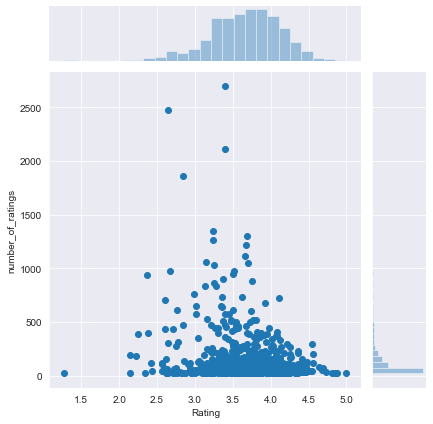

In [34]:
#Anzeigen der Ratingverteilung der User
ratings = pd.DataFrame(df.groupby('Cust_Id')['Rating'].mean())
ratings['number_of_ratings'] = df.groupby('Cust_Id')['Rating'].count()
sns.jointplot(x='Rating', y='number_of_ratings', data=ratings)

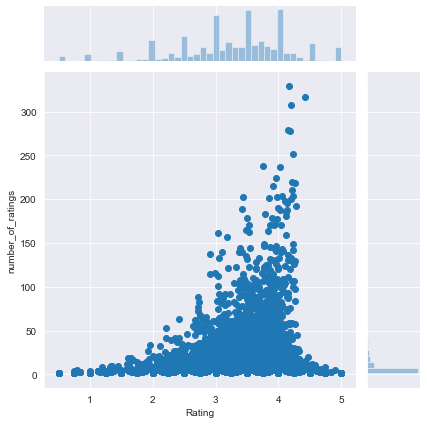

In [35]:
#Anzeigen der Ratingverteilung der Filme
ratings = pd.DataFrame(df.groupby('Movie_Id')['Rating'].mean())
ratings['number_of_ratings'] = df.groupby('Movie_Id')['Rating'].count()
sns.jointplot(x='Rating', y='number_of_ratings', data=ratings)

In [36]:
"""
Um etwas Zugriff zu bekommen, werden User und Filme rausgeschmissen, die zu wenig Bewertungen bekommen.
Inhaltlich passt dies auch, da diese Nutzer zuerst auf anderem Wege (Cold Start) Vorschläge erhalten
"""
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 7.0
Customer minimum times of review: 140.0


In [37]:
#Umformung vom Datensatz in eine Matrix (Für die Nutzbarkeit)
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

df_p

Movie_Id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
Cust_Id,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
"""
Der zweite Teil (Anwendbar auf jeden Datensatz, solange das Format stimmt):
- Cross Validation
- Train Test Split
- Mit dem SVD-Algorithmus Vorhersagen der fehlenden Ratings in der Matrix treffen
- Ausgabe von Fehlergrößen MAE (Durchschnittlicher Abweichungsfehler) und RMSE (Root Mean Square Error)
"""

'\nDer zweite Teil (Anwendbar auf jeden Datensatz, solange das Format stimmt):\n- Cross Validation\n- Train Test Split\n- Mit dem SVD-Algorithmus Vorhersagen der fehlenden Ratings in der Matrix treffen\n- Ausgabe von Fehlergrößen MAE (Durchschnittlicher Abweichungsfehler) und RMSE (Root Mean Square Error)\n'

In [39]:
#Cross Validieren
reader = Reader()
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8718  0.8707  0.8672  0.8783  0.8792  0.8734  0.0046  
MAE (testset)     0.6692  0.6696  0.6676  0.6735  0.6756  0.6711  0.0030  
Fit time          5.66    5.68    5.77    6.49    6.42    6.00    0.37    
Test time         0.17    0.44    0.18    0.19    0.16    0.23    0.11    


{'test_rmse': array([0.87178439, 0.87073773, 0.86716128, 0.87830336, 0.87921497]),
 'test_mae': array([0.66916051, 0.66955289, 0.6676445 , 0.67354349, 0.67564427]),
 'fit_time': (5.664615869522095,
  5.677841901779175,
  5.774036169052124,
  6.487320899963379,
  6.416096925735474),
 'test_time': (0.16931700706481934,
  0.439420223236084,
  0.17811107635498047,
  0.18647384643554688,
  0.16022825241088867)}

In [40]:
"""
Der SVD Algorithmus:
- Matrix Faktorisierung
- Bekanntheit durch sehr gute Arbeit beim Netflix Prize erlangt (deswegen für den ersten Teil, Nutzenmaximierung, sinnvoll)
- Versucht, unbekannte Ratings vorherzusagen aufgrund von gegebenen Ratings und anderen Nutzern
- Dokumentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
"""

'\nDer SVD Algorithmus:\n- Matrix Faktorisierung\n- Bekanntheit durch sehr gute Arbeit beim Netflix Prize erlangt (deswegen für den ersten Teil, Nutzenmaximierung, sinnvoll)\n- Versucht, unbekannte Ratings vorherzusagen aufgrund von gegebenen Ratings und anderen Nutzern\n- Dokumentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD\n'

In [41]:
#Aufteilen des Datensatzes in Trainings- und Testdaten (75 zu 25 Prozent)
trainset, testset = train_test_split(data, test_size=.25)

#Anwenden des SVD Algorithmus, um Ratings im Testset vorherzusagen 
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

#Ausgabe des RootMeanSquaredError und MeanAbsoluteError
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

RMSE: 0.8845
0.8844938333353562
MAE:  0.6790
0.6790116643359262


In [42]:
# Ausgabe der Vorhersagedaten als Dataframe
# uid = UserId, iid = FilmId, r_ui = tatsächliches Rating gegeben, est = Vorhersage
pred_df = pd.DataFrame(predictions)
pred_df = pred_df.drop(['details'], axis=1)
pred_df.head()

,uid,iid,r_ui,est
0,5,21,4.0,3.454336
1,384,2409,2.0,2.925052
2,98,177765,5.0,3.640001
3,610,122924,3.5,3.519005
4,232,5481,3.5,2.600519


In [43]:
#Kombination der Film_Ids und Titel
df_title = pd.read_csv('movies100k.csv')
df_title.set_index('movieId', inplace = True)
df_title = df_title.drop(['genres'], axis=1)
df_title = df_title.rename(columns={"movieId": "Movie_Id", "title": "Name"})
df_title.index.names = ['Movie_Id']
df_title.head()

,Name
Movie_Id,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)


In [44]:
"""
Der dritte Teil
- Funktion, um einem User n-Vorschläge zu machen
- Hilfsfunktion, um alle 5 Sterne Filme eines Users anzuzeigen, um ggf. gute Vorhersagen nachzuvollziehen
"""

'\nDer dritte Teil\n- Funktion, um einem User n-Vorschläge zu machen\n- Hilfsfunktion, um alle 5 Sterne Filme eines Users anzuzeigen, um ggf. gute Vorhersagen nachzuvollziehen\n'

In [45]:
#Nutzen der Daten, um Vorschläge für User zu machen
def makerecommendation(user, amount):
    userdf = df_title.copy()
    userdf = userdf.reset_index()
    userdf = userdf[~userdf['Movie_Id'].isin(drop_movie_list)]

    data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
    trainset = data.build_full_trainset()
    algo.fit(trainset)
    userdf['Estimate_Score'] = userdf['Movie_Id'].apply(lambda x: svd.predict(user, x).est)
    userdf = userdf.drop('Movie_Id', axis = 1)
    userdf = userdf.sort_values('Estimate_Score', ascending=False)
    print(userdf.head(amount))

In [46]:
#Beispiel anhand von User 100, der 5 Vorschläge bekommt
print(makerecommendation(100, 5))

                                                Name  Estimate_Score
680                   Philadelphia Story, The (1940)        4.702776
4909    Eternal Sunshine of the Spotless Mind (2004)        4.684556
906                        Lawrence of Arabia (1962)        4.636581
975                            Cool Hand Luke (1967)        4.612977
4025  Grave of the Fireflies (Hotaru no haka) (1988)        4.596925
None


In [47]:
#Hilfsfunktion, um 5 Star Ratings einzelner User auszulesen
def customersupport(user):
    dframeUser = df[(df['Cust_Id'] == user) & (df['Rating'] == 5)]
    dframeUser = dframeUser.set_index('Movie_Id')
    dframeUser = dframeUser.join(df_title)['Name']
    print(dframeUser)

In [48]:
#Beispiel
customersupport(100)

Movie_Id
1101                                       Top Gun (1986)
1958                           Terms of Endearment (1983)
2423    Christmas Vacation (National Lampoon's Christm...
4041                   Officer and a Gentleman, An (1982)
5620                            Sweet Home Alabama (2002)
Name: Name, dtype: object
